### Binary Sentiment Classification of IMDb Reviews Using Gensim

In [1]:
import gensim.downloader as api
wv = api.load("word2vec-google-news-300")

In [2]:
import tarfile

# Path to the tar.gz file
tar_path = 'aclImdb_v1.tar.gz'

# Extract the tar.gz file
with tarfile.open(tar_path, 'r:gz') as tar:
    tar.extractall()

In [3]:
import os
import pandas as pd

# Function to load reviews from a directory into a DataFrame
def load_reviews_to_df(directory):
    reviews = []
    labels = []
    for label in ['pos', 'neg']:
        labeled_dir = os.path.join(directory, label)
        for filename in os.listdir(labeled_dir):
            if filename.endswith('.txt'):
                with open(os.path.join(labeled_dir, filename), 'r', encoding='utf-8') as file:
                    reviews.append(file.read())
                    labels.append('Positive' if label == 'pos' else 'Negative')
    return pd.DataFrame({'Review': reviews, 'Label': labels})

# Load training and testing data
train_dir = 'aclImdb/train'
test_dir = 'aclImdb/test'

train_df = load_reviews_to_df(train_dir)
test_df = load_reviews_to_df(test_dir)

In [4]:
train_df.head()

,Review,Label
0,Bromwell High is a cartoon comedy. It ran at t...,Positive
1,Homelessness (or Houselessness as George Carli...,Positive
2,Brilliant over-acting by Lesley Ann Warren. Be...,Positive
3,This is easily the most underrated film inn th...,Positive
4,This is not the typical Mel Brooks film. It wa...,Positive


### Data Exploration

##### Check if there is a class imbalance 

In [5]:
train_df.Label.value_counts()

Label
Positive    12500
Negative    12500
Name: count, dtype: int64

In [6]:
test_df.Label.value_counts()

Label
Positive    12500
Negative    12500
Name: count, dtype: int64

The dataset contains 25,000 movie reviews from IMDb, which can either be positive or negative. The dataset is balanced, with 12,500 positive reviews and 12,500 negative reviews.

##### Create a class for these labels

In [7]:
train_df['label_num'] = train_df['Label'].map({
    'Positive': 0,
    'Negative': 1
})
train_df.head()

,Review,Label,label_num
0,Bromwell High is a cartoon comedy. It ran at t...,Positive,0
1,Homelessness (or Houselessness as George Carli...,Positive,0
2,Brilliant over-acting by Lesley Ann Warren. Be...,Positive,0
3,This is easily the most underrated film inn th...,Positive,0
4,This is not the typical Mel Brooks film. It wa...,Positive,0


In [8]:
test_df['label_num'] = train_df['Label'].map({
    'Positive': 0,
    'Negative': 1
})
test_df.head()

,Review,Label,label_num
0,I went and saw this movie last night after bei...,Positive,0
1,Actor turned director Bill Paxton follows up h...,Positive,0
2,As a recreational golfer with some knowledge o...,Positive,0
3,"I saw this film in a sneak preview, and it is ...",Positive,0
4,Bill Paxton has taken the true story of the 19...,Positive,0


#### Preprocessing data to get them ready for modeling

In [9]:
import spacy

nlp = spacy.load("en_core_web_lg")

In [10]:
# 
def preprocess_and_vectorize(text):
    doc = nlp(text)                    # Tokenize and process text with spaCy
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:        # Filter out stop words and punctuation
            continue
        filtered_tokens.append(token.lemma_)       # Lemmatize remaining tokens
    return wv.get_mean_vector(filtered_tokens)     # Vectorize the text using word vectors

#### convert text into word embedding using gensim

In [11]:
%%time
train_df['Preprocessed_Review'] = train_df['Review'].apply(lambda Review: preprocess_and_vectorize(Review))
test_df['Preprocessed_Review'] = test_df['Review'].apply(lambda Review: preprocess_and_vectorize(Review))

print(train_df.head())
print(test_df.head())

                                              Review     Label  label_num  \
0  Bromwell High is a cartoon comedy. It ran at t...  Positive          0   
1  Homelessness (or Houselessness as George Carli...  Positive          0   
2  Brilliant over-acting by Lesley Ann Warren. Be...  Positive          0   
3  This is easily the most underrated film inn th...  Positive          0   
4  This is not the typical Mel Brooks film. It wa...  Positive          0   

                                 Preprocessed_Review  
0  [0.02048781, 0.0083551025, 0.0076504354, 0.035...  
1  [0.018606685, 0.007945998, -0.0011602048, 0.03...  
2  [0.0283205, 0.016694989, -0.011100194, 0.01902...  
3  [0.015744613, 0.004762898, -0.017555969, 0.030...  
4  [0.0406657, 0.0014400244, -0.025357867, 0.0280...  
                                              Review     Label  label_num  \
0  I went and saw this movie last night after bei...  Positive          0   
1  Actor turned director Bill Paxton follows up h... 

#### Train and Test split

In [13]:
X_train = train_df['Preprocessed_Review']
X_test = test_df['Preprocessed_Review']
y_train = train_df['label_num']
y_test = test_df['label_num']

#### Reshaping of X_train and X_test as to fit for the model

In [15]:
import numpy as np
print("Shape of X_train before reshaping: ", X_train.shape)
print("Shape of X_test before reshaping: ", X_test.shape)

X_train_2d = np.stack(X_train)
X_test_2d = np.stack(X_test)

print("Shape of X_train_2d before reshaping: ", X_train_2d.shape)
print("Shape of X_test_2d before reshaping: ", X_test_2d.shape)

Shape of X_train before reshaping:  (25000,)
Shape of X_test before reshaping:  (25000,)
Shape of X_train_2d before reshaping:  (25000, 300)
Shape of X_test_2d before reshaping:  (25000, 300)


### Modeling

In this project I will train two models and evaluate their performances
1. Random forest 
2. Gradient Boosting

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12500
           1       1.00      1.00      1.00     12500

    accuracy                           1.00     25000
   macro avg       1.00      1.00      1.00     25000
weighted avg       1.00      1.00      1.00     25000



Text(95.72222222222221, 0.5, 'True')

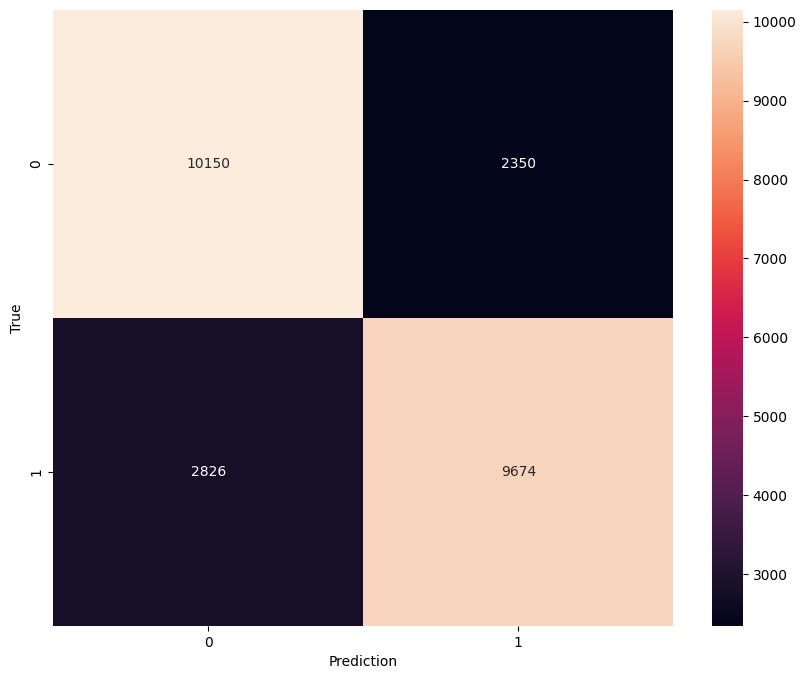

In [17]:
# Random Forest Model

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix

clf = RandomForestClassifier()

clf.fit(X_train_2d, y_train)

y_pred = clf.predict(X_test_2d)

print(classification_report(y_test, y_test))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('True')

The random forest model achieved perfect performance on the test data, with precision, recall, and F1-scores all at 1.00 for both classes (0 and 1), across 12,500 samples per class. The overall accuracy is also 1.00. Additionally, the confusion matrix indicates that 79.2% of the test data was correctly classified.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12500
           1       1.00      1.00      1.00     12500

    accuracy                           1.00     25000
   macro avg       1.00      1.00      1.00     25000
weighted avg       1.00      1.00      1.00     25000



Text(95.72222222222221, 0.5, 'True')

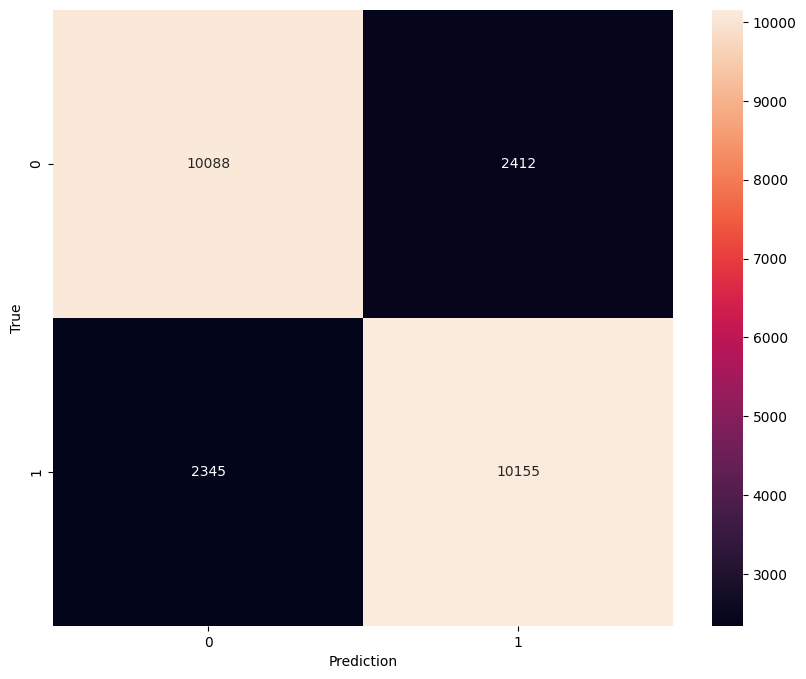

In [19]:
# Gradient Boosting Model

from sklearn.ensemble import GradientBoostingClassifier 

clf = GradientBoostingClassifier()

clf.fit(X_train_2d, y_train)

y_pred = clf.predict(X_test_2d)

print(classification_report(y_test, y_test))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('True')

The gradient boosting model, like the random forest model, performed excellently on the datasets, achieving perfect scores in precision, recall, and F1-score (1.00) for both classes (0 and 1), across 12,500 samples per class. The overall accuracy is also 1.00. Despite the perfect classification report making it hard to distinguish which model performed better, the gradient boosting model correctly predicted 80.9% of the data, indicating it is slightly ahead of the random forest model in this aspect.